In [216]:
import pandas as pd
import re
import numpy as np
import snowballstemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import preprocessor as p
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [2]:
pd.DataFramenn_results

846

In [3]:
data.columns

Index(['Tweets', 'Is_Conspiracy (0=No, 1=Yes)'], dtype='object')

## Tweet Cleaning

In [4]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY)

In [5]:
def clean_tweet(row):
    text = p.clean(row['Tweets'])
    row['filtered_tweet'] = re.sub('\d', 'NUM', text)
    return row

In [6]:
data = data.apply(lambda row: clean_tweet(row), axis =1)

In [7]:
data = data[pd.notnull(data['filtered_tweet'])]
data = data[pd.notnull(data['Is_Conspiracy (0=No, 1=Yes)'])]
len(data)

835

In [8]:
data['Is_Conspiracy (0=No, 1=Yes)'].value_counts()

0.0    747
1.0     88
Name: Is_Conspiracy (0=No, 1=Yes), dtype: int64

In [9]:
## Over Sampling

In [10]:
values = []
for idx, val in data.iterrows():
    if val['Is_Conspiracy (0=No, 1=Yes)'] == 1:
        for i in range(5):
            values.append(val)
    else:
        values.append(val)

In [11]:
data = pd.DataFrame(values)

In [12]:
data['Is_Conspiracy (0=No, 1=Yes)'].value_counts()

0.0    747
1.0    440
Name: Is_Conspiracy (0=No, 1=Yes), dtype: int64

In [13]:
data = data.sample(frac=1, random_state=7).reset_index(drop=True)

In [14]:
data.head()

,Tweets,"Is_Conspiracy (0=No, 1=Yes)",filtered_tweet
0,"@rickgladstone He didn't just TRY, he did and ...",1.0,"@rickgladstone He didn't just TRY, he did and ..."
1,Wuhan Central Hospital denies death of #corona...,1.0,Wuhan Central Hospital denies death of #corona...
2,"So where in Europe did they fly, can we all kn...",0.0,"So where in Europe did they fly, can we all kn..."
3,I am so sad. They need help https://t.co/Nk9ZR...,0.0,I am so sad. They need help
4,Chinese multinational conglomerate company Ten...,1.0,Chinese multinational conglomerate company Ten...


## TF-IDF Vectorization

In [15]:
english_stemmer = snowballstemmer.stemmer('english')
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: english_stemmer.stemWords(analyzer(doc))

In [16]:
tfidf_vect = StemmedTfidfVectorizer(min_df=5, stop_words='english', analyzer='word', ngram_range=(1,2), max_features=2500, norm='l2', encoding='utf-8')

In [17]:
sentence_term_tfidf = tfidf_vect.fit_transform(data['filtered_tweet'])
sentence_term_df = pd.DataFrame(sentence_term_tfidf.todense(), columns=np.sort(list(tfidf_vect.vocabulary_.keys())))
sentence_term_df.columns = sentence_term_df.columns.map(lambda x: 'W_'+'_'+x)

In [18]:
sentence_term_df.head(5)

,W__abl,W__able provid,W__absolut,W__absolute hero,W__abt,W__abt coronavirus,W__abtc,W__accident,W__accidentally leak,W__accidentally pnum,...,W__yeah sur,W__year,W__youtub,W__youtube xr,W__yr,W__yr old,W__李文亮,W__李文亮 china,W__自相矛盾natur,W__自相矛盾nature chines
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119826,0.127781,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
sentence_term_df.shape

(1187, 2081)

In [20]:
labels = data['Is_Conspiracy (0=No, 1=Yes)']
labels.shape

(1187,)

In [21]:
features = sentence_term_df.values

In [22]:
features.shape

(1187, 2081)

## Train-Test Split for All Models

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [25]:
len(X_train), len(X_test)

(830, 357)

## Classification Report

In [26]:
## For printing CLassification report with Accuracy
def print_classification_result(y_test, y_pred):
    target_names = ['Non-Conspiracy', 'Conspiracy']
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Avg. Accuracy: ', accuracy_score(y_test, y_pred))
    print('Specifity: ', specificity)

## Milestone 3 Code

### SVM

In [27]:
from sklearn import svm

In [28]:
svm_clf = svm.SVC()

In [29]:
sv_trained = svm_clf.fit(X_train,y_train)
y_pred = sv_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       1.00      0.99      0.99       228
    Conspiracy       0.98      1.00      0.99       129

      accuracy                           0.99       357
     macro avg       0.99      0.99      0.99       357
  weighted avg       0.99      0.99      0.99       357

Avg. Accuracy:  0.9915966386554622
Specifity:  0.9868421052631579


In [30]:
## Replacing Kernels

In [31]:
for kernel in ('linear', 'poly'):
    svm_clf = svm.SVC(kernel=kernel)
    sv_trained = svm_clf.fit(X_train,y_train)
    y_pred = sv_trained.predict(X_test)
    print("=================== For " + kernel+  " Kernel ================")
    print_classification_result(y_test, y_pred)

=================== For linear Kernel ================
                precision    recall  f1-score   support

Non-Conspiracy       0.96      0.96      0.96       228
    Conspiracy       0.93      0.94      0.93       129

      accuracy                           0.95       357
     macro avg       0.95      0.95      0.95       357
  weighted avg       0.95      0.95      0.95       357

Avg. Accuracy:  0.9523809523809523
Specifity:  0.9605263157894737
=================== For poly Kernel ================
                precision    recall  f1-score   support

Non-Conspiracy       1.00      0.99      0.99       228
    Conspiracy       0.98      1.00      0.99       129

      accuracy                           0.99       357
     macro avg       0.99      0.99      0.99       357
  weighted avg       0.99      0.99      0.99       357

Avg. Accuracy:  0.9915966386554622
Specifity:  0.9868421052631579


### NN Model

In [188]:
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [189]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['filtered_tweet'].values)
X1 = tokenizer.texts_to_sequences(data['filtered_tweet'].values)
X1 = pad_sequences(X1)

/home/rony/anaconda3/lib/python3.8/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [190]:
Y1 = pd.get_dummies(data['Is_Conspiracy (0=No, 1=Yes)']).values
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, random_state = 42)
print(X1_train.shape,Y1_train.shape)
print(X1_test.shape,Y1_test.shape)

(890, 54) (890, 2)
(297, 54) (297, 2)


In [193]:
y_test = []
for ent in Y1_test:
    if ent[0] == 1:
        y_test.append(0)
    else:
        y_test.append(1)
y_test= np.asarray(y_test)

In [213]:
embed_dim = 200
lstm_out = 200
max_features = 3000

In [214]:
def NN_model(hidden_layer):
    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
    model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
    for i in range(hidden_layer):
        model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
    yhat_classes = model.predict_classes(X1_test, verbose=0)
    accuracy = accuracy_score(y_test, yhat_classes)
    return {'layer': hidden_layer, 'accuracy': accuracy}

In [215]:
nn_results = []
for i in [1,2,3,4,5]:
    nn_results.append(NN_model(i))

<ipython-input-214-22b6d9e17048>:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-214-22b6d9e17048>:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-214-22b6d9e17048>:8: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)


In [218]:
nn_per = pd.DataFrame(nn_results)

In [219]:
nn_per

,layer,accuracy
0,1,0.983165
1,2,0.622896
2,3,0.622896
3,4,0.983165
4,5,0.622896


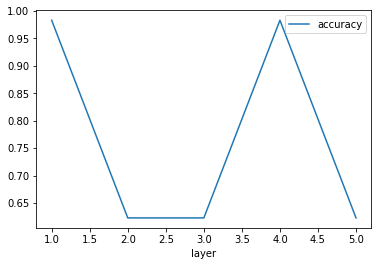

In [221]:
lines = nn_per.plot.line(x='layer', y='accuracy')

In [239]:
## Visualization

In [240]:
embed_dim = 200
lstm_out = 200
max_features = 3000
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)

<ipython-input-240-fc4637f35220>:5: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-240-fc4637f35220>:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-240-fc4637f35220>:9: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


In [249]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation
import json

network = Sequential()


def build_cnn_model():
  model = keras.models.Sequential()

  model.add(Dense(2, input_shape=(200,)))
#   model.add(Activation('sigmoid'))
#   model.add(Dense(60))
#   model.add(Activation('sigmoid'))
#   model.add(Dense(1))

  return model

network = build_cnn_model()

from ann_visualizer.visualize import ann_viz

ann_viz(network, title="", view=True)

print(network.layers[0].get_config())

{'name': 'dense_94', 'trainable': True, 'batch_input_shape': (None, 200), 'dtype': 'float32', 'units': 2, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}


### Clustering

#### kMeans

In [183]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

documents = data['filtered_tweet'].values.tolist()

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
predicted_lables = model.labels_.tolist()
original_lables = data['Is_Conspiracy (0=No, 1=Yes)'].values.tolist()

In [184]:
class_0 = 0
class_1 = 0
for pred in predicted_lables:
    if pred == 0:
        class_0 += 1
    else:
        class_1 += 1

In [185]:
class_0, class_1

(890, 297)

In [186]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 coronavirus
 china
 virus
 num
 amp
 coronavirusoutbreak
 wuhan
 news
 people
 trump
Cluster 1:
 coronavirus
 chinese
 doctor
 china
 wuhan
 truth
 li
 numnum
 numnumnum
 died


### Hierarchical Clustering

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
import scipy.cluster.hierarchy as shc

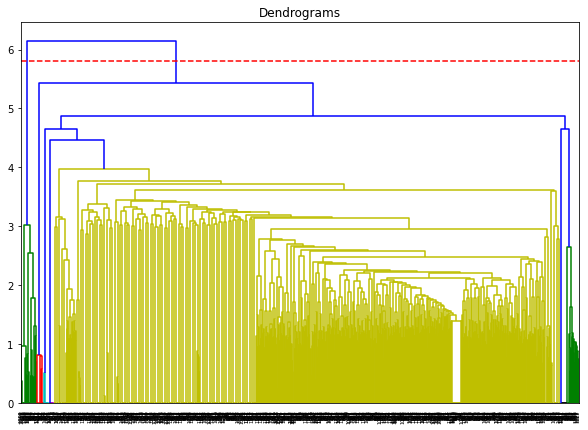

In [74]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(sentence_term_df, method='ward'))
plt.axhline(y=5.8, color='r', linestyle='--')

In [75]:
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
predictions = cluster.fit_predict(sentence_term_df)

In [76]:
class_0 = 0
class_1 = 0
for pred in predictions:
    if pred == 0:
        class_0 += 1
    else:
        class_1 += 1

In [77]:
class_0, class_1

(1153, 34)

#### DBScan

In [78]:
from sklearn.cluster import DBSCAN

In [109]:
clustering = DBSCAN(min_samples=6).fit(sentence_term_df)

In [110]:
clustering.labels_

array([-1, -1, -1, ..., -1, -1, -1])

In [111]:
cluster_map = {}
for cluster in clustering.labels_:
    if cluster not in cluster_map:
        cluster_map[cluster] = 0
        cluster_map[cluster] += 1
    else:
        cluster_map[cluster] += 1

In [112]:
cluster_map

{-1: 1078, 0: 13, 1: 10, 2: 13, 3: 20, 4: 6, 5: 11, 6: 16, 7: 6, 8: 6, 9: 8}

### Comparative Analysis

In [96]:
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [103]:
def model_classification(model, train, test):
    X_train = sentence_term_df.iloc[train].values
    X_test = sentence_term_df.iloc[test].values
    y_train = data.iloc[train]['Is_Conspiracy (0=No, 1=Yes)']
    y_test = data.iloc[test]['Is_Conspiracy (0=No, 1=Yes)']
#     svm_clf = svm.SVC()
    trained = model.fit(X_train,y_train)
    y_pred = trained.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

In [114]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['filtered_tweet'].values)
X1 = tokenizer.texts_to_sequences(data['filtered_tweet'].values)
X1 = pad_sequences(X1)

/home/rony/anaconda3/lib/python3.8/site-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [141]:
max_fatures = 3000
tokenizer = Tokenizer(nb_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['filtered_tweet'].values)
X1 = tokenizer.texts_to_sequences(data['filtered_tweet'].values)
Y1 = pd.get_dummies(data['Is_Conspiracy (0=No, 1=Yes)']).values
X1 = pad_sequences(X1)

In [161]:
def classification_report_for_NN(train,test):
#     print(len(train), len(test))
    X1_train = X1[train]
    X1_test = X1[test]
    Y1_train = Y1[train]
    Y1_test = Y1[test]
    
    embed_dim = 150
    lstm_out = 200
    max_features = 3000

    model = Sequential()
    model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
    model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    batch_size = 32
    model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
    yhat_classes = model.predict_classes(X1_test, verbose=0)
    y_test = []
    for ent in Y1_test:
        if ent[0] == 1:
            y_test.append(0)
        else:
            y_test.append(1)
    y_test= np.asarray(y_test)
    accuracy = accuracy_score(y_test, yhat_classes)
    precision = precision_score(y_test, yhat_classes, average='macro')
    recall = recall_score(y_test, yhat_classes, average='macro')
    f1 = f1_score(y_test, yhat_classes, average='macro')
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

In [124]:
## K-fold Cross 

In [145]:
kf = KFold(n_splits=5)
kf.get_n_splits(data.index.values)
svm_scores = []
dt_scores = []
rf_scores = []
nn_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
for train, test in kf.split(data):
    svm_scores.append(model_classification(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification(dt, train, test))
    rf_scores.append(model_classification(rf, train, test))
    nn_scores.append(classification_report_for_NN(train,test))

<ipython-input-142-1aa10c86d4d0>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-142-1aa10c86d4d0>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-142-1aa10c86d4d0>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 2)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/10
 - 3s - loss: 0.5950 - accuracy: 0.6870
Epoch 2/10
 - 4s - loss: 0.3080 - accuracy: 0.8925
Epoch 3/10
 - 3s - loss: 0.0753 - accuracy: 0.9800
Epoch 4/10
 - 3s - loss: 0.0345 - accuracy: 0.9947
Epoch 5/10
 - 3s - loss: 0.0139 - accuracy: 0.9989
Epoch 6/10
 - 3s - loss: 0.0079 - accuracy: 0.9979
Epoch 7/10
 - 3s - loss: 0.0158 - accuracy: 0.9958
Epoch 8/10
 - 3s - loss: 0.0080 - accuracy: 0.9989
Epoch 9/10
 - 3s - loss: 0.0128 - accuracy: 0.9968
Epoch 10/10
 - 3s - loss: 0.0049 - accuracy: 0.9989


<ipython-input-142-1aa10c86d4d0>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-142-1aa10c86d4d0>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-142-1aa10c86d4d0>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 2)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/10
 - 3s - loss: 0.5804 - accuracy: 0.7155
Epoch 2/10
 - 3s - loss: 0.2840 - accuracy: 0.8988
Epoch 3/10
 - 3s - loss: 0.0623 - accuracy: 0.9852
Epoch 4/10
 - 3s - loss: 0.0221 - accuracy: 0.9958
Epoch 5/10
 - 3s - loss: 0.0079 - accuracy: 0.9979
Epoch 6/10
 - 3s - loss: 0.0082 - accuracy: 0.9979
Epoch 7/10
 - 3s - loss: 0.0024 - accuracy: 1.0000
Epoch 8/10
 - 3s - loss: 0.0012 - accuracy: 1.0000
Epoch 9/10
 - 3s - loss: 7.1279e-04 - accuracy: 1.0000
Epoch 10/10
 - 3s - loss: 5.6382e-04 - accuracy: 1.0000


<ipython-input-142-1aa10c86d4d0>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-142-1aa10c86d4d0>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-142-1aa10c86d4d0>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 2)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/10
 - 3s - loss: 0.6035 - accuracy: 0.6968
Epoch 2/10
 - 3s - loss: 0.3162 - accuracy: 0.8821
Epoch 3/10
 - 4s - loss: 0.0740 - accuracy: 0.9832
Epoch 4/10
 - 3s - loss: 0.0281 - accuracy: 0.9937
Epoch 5/10
 - 3s - loss: 0.0368 - accuracy: 0.9916
Epoch 6/10
 - 3s - loss: 0.0174 - accuracy: 0.9968
Epoch 7/10
 - 3s - loss: 0.0109 - accuracy: 0.9989
Epoch 8/10
 - 3s - loss: 0.0094 - accuracy: 0.9989
Epoch 9/10
 - 3s - loss: 0.0099 - accuracy: 0.9989
Epoch 10/10
 - 3s - loss: 0.0070 - accuracy: 0.9989


<ipython-input-142-1aa10c86d4d0>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-142-1aa10c86d4d0>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-142-1aa10c86d4d0>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 2)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/10
 - 5s - loss: 0.6098 - accuracy: 0.6779
Epoch 2/10
 - 3s - loss: 0.2911 - accuracy: 0.9063
Epoch 3/10
 - 3s - loss: 0.0923 - accuracy: 0.9747
Epoch 4/10
 - 3s - loss: 0.0225 - accuracy: 0.9937
Epoch 5/10
 - 3s - loss: 0.0197 - accuracy: 0.9958
Epoch 6/10
 - 3s - loss: 0.0166 - accuracy: 0.9989
Epoch 7/10
 - 3s - loss: 0.0088 - accuracy: 0.9989
Epoch 8/10
 - 3s - loss: 0.0096 - accuracy: 0.9989
Epoch 9/10
 - 3s - loss: 0.0085 - accuracy: 0.9979
Epoch 10/10
 - 3s - loss: 0.0136 - accuracy: 0.9968


<ipython-input-142-1aa10c86d4d0>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-142-1aa10c86d4d0>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-142-1aa10c86d4d0>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 2)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Epoch 1/10
 - 3s - loss: 0.5839 - accuracy: 0.7063
Epoch 2/10
 - 5s - loss: 0.2906 - accuracy: 0.9032
Epoch 3/10
 - 3s - loss: 0.0788 - accuracy: 0.9811
Epoch 4/10
 - 3s - loss: 0.0338 - accuracy: 0.9937
Epoch 5/10
 - 3s - loss: 0.0210 - accuracy: 0.9937
Epoch 6/10
 - 3s - loss: 0.0174 - accuracy: 0.9968
Epoch 7/10
 - 3s - loss: 0.0122 - accuracy: 0.9989
Epoch 8/10
 - 3s - loss: 0.0088 - accuracy: 0.9989
Epoch 9/10
 - 3s - loss: 0.0060 - accuracy: 0.9979
Epoch 10/10
 - 3s - loss: 0.0100 - accuracy: 0.9989


In [108]:
def dict_mean(dict_list):
    mean_dict = {}
    for key in dict_list[0].keys():
        mean_dict[key] = sum(d[key] for d in dict_list) / len(dict_list)
    return mean_dict

In [146]:
model_scores = [svm_scores, dt_scores, rf_scores, nn_scores]

In [150]:
model_map = {0: 'SVM', 1: 'Decision Tree', 2: 'Random Forest', 3: 'Neural Net'}

In [155]:
results = []
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'kFold'
    results.append(score_mean)

In [157]:
## LeavePOut

In [162]:
from sklearn.model_selection import LeavePOut
lpo = LeavePOut(300)
lpo.get_n_splits(data.index.values)
svm_scores = []
dt_scores = []
rf_scores = []
nn_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
count = 0
for train, test in lpo.split(data):
    count += 1
    svm_scores.append(model_classification(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification(dt, train, test))
    rf_scores.append(model_classification(rf, train, test))
    nn_scores.append(classification_report_for_NN(train,test))
    if count == 5:
        break

<ipython-input-161-b0a77924c317>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-161-b0a77924c317>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-161-b0a77924c317>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
<ipython-input-161-b0a77924c317>:13: UserWarning: The `dropout` argument 

In [164]:
model_scores = [svm_scores, dt_scores, rf_scores, nn_scores]
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'LeavePOut'
    results.append(score_mean)

In [166]:
## Random Split

In [169]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([0, 0, 0, 1, 1, 1])
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
sss.get_n_splits(X, y)

print(sss)

for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]

StratifiedShuffleSplit(n_splits=5, random_state=0, test_size=0.5,
            train_size=None)
TRAIN: [5 2 3] TEST: [4 1 0]
TRAIN: [5 1 4] TEST: [0 2 3]
TRAIN: [5 0 2] TEST: [4 3 1]
TRAIN: [4 1 0] TEST: [2 3 5]
TRAIN: [0 5 1] TEST: [3 4 2]


In [170]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=42)
sss.get_n_splits(features, labels)
svm_scores = []
dt_scores = []
rf_scores = []
nn_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
for train, test in sss.split(features, labels):
    count += 1
    svm_scores.append(model_classification(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification(dt, train, test))
    rf_scores.append(model_classification(rf, train, test))
    nn_scores.append(classification_report_for_NN(train,test))

<ipython-input-161-b0a77924c317>:13: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  model.add(Embedding(max_features, embed_dim,input_length = X1_train.shape[1], dropout=0.2))
<ipython-input-161-b0a77924c317>:14: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(200, dropout=0.2, recurrent_dropout=0.2)`
  model.add(LSTM(lstm_out, dropout_U=0.2,dropout_W=0.2))
<ipython-input-161-b0a77924c317>:18: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X1_train, Y1_train, nb_epoch = 10,verbose = 0)
/home/rony/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
<ipython-input-161-b0a77924c317>:13: UserWarning: The `dropout` argument 

In [171]:
model_scores = [svm_scores, dt_scores, rf_scores, nn_scores]
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'Random SubSampling'
    results.append(score_mean)

In [174]:
pd.DataFrame(results)

,precision,recall,f1,accuracy,model,CV
0,0.992572,0.993342,0.992908,0.993270,SVM,kFold
1,0.965547,0.978635,0.971044,0.973021,Decision Tree,kFold
2,0.990082,0.993938,0.991898,0.992423,Random Forest,kFold
3,0.955477,0.972103,0.962100,0.964603,Neural Net,kFold
4,0.988381,0.992323,0.990252,0.990667,SVM,LeavePOut
5,0.981193,0.987387,0.984026,0.984667,Decision Tree,LeavePOut
6,0.987562,0.991776,0.989557,0.990000,Random Forest,LeavePOut
7,0.972101,0.980805,0.975795,0.976667,Neural Net,LeavePOut
8,0.980704,0.971230,0.975531,0.977441,SVM,Random SubSampling
9,0.956023,0.962701,0.958840,0.961279,Decision Tree,Random SubSampling


In [178]:
pd.DataFrame(results).round(3).to_csv('results_comparison.csv', index=False)

## Feature Selection

In [223]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

In [230]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),
                    ('classification', DecisionTreeClassifier())
                   ])
trained = clf.fit(X_train, y_train)
y_pred = trained.predict(X_test)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print(precision, recall, accuracy, f1)

0.9479166666666667 0.9671052631578947 0.957983193277311 0.9555206698063841


/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:225: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  warnings.warn(msg % (old_loss, self.loss, old_loss, '0.23'),


In [235]:
def model_classification_pipeline(model, train, test):
    X_train = sentence_term_df.iloc[train].values
    X_test = sentence_term_df.iloc[test].values
    y_train = data.iloc[train]['Is_Conspiracy (0=No, 1=Yes)']
    y_test = data.iloc[test]['Is_Conspiracy (0=No, 1=Yes)']
    clf = Pipeline([('feature_selection', SelectFromModel(LinearSVC(loss='l2', penalty='l1', dual=False))),
                    ('classification', model)
                   ])
    trained = clf.fit(X_train,y_train)
    y_pred = trained.predict(X_test)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    return {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}

In [236]:
kf = KFold(n_splits=5)
kf.get_n_splits(data.index.values)
svm_scores = []
dt_scores = []
rf_scores = []
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(n_estimators=140)
for train, test in kf.split(data):
    svm_scores.append(model_classification_pipeline(svc, train, test))
#     nn_p, nn_r, nn_f, nn_a = nn_classification(train, test)
    dt_scores.append(model_classification_pipeline(dt, train, test))
    rf_scores.append(model_classification_pipeline(rf, train, test))
#     nn_scores.append(classification_report_for_NN(train,test))

/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:225: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  warnings.warn(msg % (old_loss, self.loss, old_loss, '0.23'),
/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:225: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  warnings.warn(msg % (old_loss, self.loss, old_loss, '0.23'),
/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:225: FutureWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 0.23
  warnings.warn(msg % (old_loss, self.loss, old_loss, '0.23'),
/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py:225: FutureWarning: loss='l2' has been 

In [237]:
fs_results = []
model_scores = [svm_scores, dt_scores, rf_scores]
for p in range(len(model_scores)):
    score_mean = dict_mean(model_scores[p])
    score_mean['model'] = model_map[p]
    score_mean['CV'] = 'kFold'
    fs_results.append(score_mean)

In [238]:
pd.DataFrame(fs_results)

,precision,recall,f1,accuracy,model,CV
0,0.954980,0.970127,0.961260,0.963773,SVM,kFold
1,0.964621,0.976893,0.969702,0.971347,Decision Tree,kFold
2,0.984685,0.990531,0.987348,0.988196,Random Forest,kFold


## Milestone 2 code

## LogisticRegression

In [28]:
## For printing CLassification report with Accuracy
def print_classification_result(y_test, y_pred):
    target_names = ['Non-Conspiracy', 'Conspiracy']
    print(classification_report(y_test, y_pred, target_names=target_names))
    print('Avg. Accuracy: ', accuracy_score(y_test, y_pred))

In [29]:
lg_model = LogisticRegression(random_state=0)
lg_trained = lg_model.fit(X_train,y_train)
y_pred = lg_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       0.93      0.98      0.96       228
    Conspiracy       0.97      0.87      0.91       129

      accuracy                           0.94       357
     macro avg       0.95      0.93      0.93       357
  weighted avg       0.94      0.94      0.94       357

Avg. Accuracy:  0.9411764705882353


In [30]:
## Intercept
lg_trained.intercept_

array([-0.56847959])

In [31]:
lg_trained.coef_

array([[-0.15634059,  0.2509336 , -0.00130538, ...,  0.22229934,
         0.5096754 ,  0.5096754 ]])

In [155]:
import statsmodels.api as sm
mod = sm.OLS(y_train,X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']

/home/rony/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/home/rony/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/rony/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/rony/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [160]:
sig_indices = []
p_list = p_values.to_list()
for i in range(len(p_list)):
    if p_list[i] < 0.05:
        sig_indices.append(i)
len(sig_indices)

190

In [181]:
import math

In [182]:
sig_features = []
feat_names = list(sentence_term_df.columns)
co_effs = list(lg_trained.coef_[0])
for i in sig_indices:
    entry = {}
    score = p_list[i]
    feature_n = feat_names[i]
    entry['name'] = feature_n
    entry['score'] = score
    entry['coeff'] = co_effs[i]
    entry['odd_ratio'] = math.exp(co_effs[i])
    sig_features.append(entry)

In [178]:
## Finding Significant Features

In [183]:
sorted(sig_features, key = lambda i: i['score'])[0:10]

[{'name': 'W__issu',
  'score': 0.0004975845739441109,
  'coeff': -0.3017825972931044,
  'odd_ratio': 0.7394988164594298},
 {'name': 'W__hide',
  'score': 0.0012807182051775472,
  'coeff': 1.1154387599752122,
  'odd_ratio': 3.0509065012209913},
 {'name': 'W__week',
  'score': 0.0013169964135552243,
  'coeff': -0.6221091048601872,
  'odd_ratio': 0.5368110520015031},
 {'name': 'W__family china',
  'score': 0.0015944051361023546,
  'coeff': 0.33371168337168183,
  'odd_ratio': 1.3961405550033277},
 {'name': 'W__armed coronavirus',
  'score': 0.0015944051361023853,
  'coeff': 0.33371168337168183,
  'odd_ratio': 1.3961405550033277},
 {'name': 'W__kill famili',
  'score': 0.001594405136102391,
  'coeff': 0.33371168337168183,
  'odd_ratio': 1.3961405550033277},
 {'name': 'W__knows big',
  'score': 0.001594405136102391,
  'coeff': 0.33371168337168183,
  'odd_ratio': 1.3961405550033277},
 {'name': 'W__said differ',
  'score': 0.001594405136102391,
  'coeff': 0.33371168337168183,
  'odd_ratio': 1

In [167]:
## Log-odd and odd-ratio

In [169]:
# odds_ratio
np.exp(lg_trained.coef_)

array([[0.85526785, 1.28522474, 0.99869547, ..., 1.24894518, 1.66475072,
        1.66475072]])

## Naive Bayes

In [34]:
from sklearn.naive_bayes import GaussianNB

In [35]:
## Gaussian Naive Bayes
gn_model = GaussianNB()
gn_trained = gn_model.fit(X_train,y_train)
y_pred = gn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       1.00      0.87      0.93       228
    Conspiracy       0.82      1.00      0.90       129

      accuracy                           0.92       357
     macro avg       0.91      0.94      0.92       357
  weighted avg       0.93      0.92      0.92       357

Avg. Accuracy:  0.9187675070028011


In [36]:
## Multinomial Naive Bayes
mn_model = MultinomialNB(alpha=0)
mn_trained = mn_model.fit(X_train,y_train)
y_pred = mn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       1.00      0.89      0.94       228
    Conspiracy       0.84      1.00      0.91       129

      accuracy                           0.93       357
     macro avg       0.92      0.95      0.93       357
  weighted avg       0.94      0.93      0.93       357

Avg. Accuracy:  0.9327731092436975


/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/naive_bayes.py:506: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


In [37]:
## Multinomial Naive Bayes
mn_model = MultinomialNB(alpha=1)
mn_trained = mn_model.fit(X_train,y_train)
y_pred = mn_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       0.83      0.99      0.90       228
    Conspiracy       0.96      0.64      0.77       129

      accuracy                           0.86       357
     macro avg       0.90      0.81      0.83       357
  weighted avg       0.88      0.86      0.85       357

Avg. Accuracy:  0.8599439775910365


## Decision Tree

In [38]:
## Original data Distribution
sentence_term_df['W__accident'].describe()

count    1187.000000
mean        0.001977
std         0.017400
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.253816
Name: W__accident, dtype: float64

In [39]:
sentence_term_df['lables'] = labels

In [40]:
## Shuffle and show new distribution

In [41]:
sentence_term_df_shuffle = sentence_term_df.sample(frac=1, random_state=100).reset_index(drop=True)

In [42]:
sentence_term_df_shuffle['W__accident'].describe()

count    1187.000000
mean        0.001977
std         0.017400
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.253816
Name: W__accident, dtype: float64

In [43]:
## Training - Testing Split
sentence_term_df_shuffle.shape

(1187, 2082)

In [44]:
features = sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].values
features.shape

(1187, 2081)

In [45]:
lables = sentence_term_df_shuffle['lables']
lables.shape

(1187,)

In [46]:
## Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=42)

In [69]:
## Training Decision tree
dt_model = DecisionTreeClassifier()
dt_trained = dt_model.fit(X_train,y_train)

In [48]:
## Size of the tree
treeObj = dt_trained.tree_
treeObj.node_count

459

In [49]:
## Tree Visualization
from sklearn import tree
import graphviz

In [56]:
dot_data = tree.export_graphviz(dt_trained, out_file=None, 
...                      feature_names=sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].columns,  
...                      class_names=['Non-Conspiracy', 'Conspiracy'],  
...                      filled=True, rounded=True,  
...                      special_characters=True)
graph = graphviz.Source(dot_data) 
graph.render("conspiracy_tweet") 

'conspiracy_tweet.pdf'

In [57]:
from sklearn.tree.export import export_text

/home/rony/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.tree.export module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


In [63]:
feature_names = list(sentence_term_df_shuffle.loc[:, sentence_term_df_shuffle.columns != 'lables'].columns)
feature_names

['W__abl',
 'W__able provid',
 'W__absolut',
 'W__absolute hero',
 'W__abt',
 'W__abt coronavirus',
 'W__abtc',
 'W__accident',
 'W__accidentally leak',
 'W__accidentally pnum',
 'W__accord',
 'W__according articl',
 'W__accur',
 'W__accurate info',
 'W__accurate inform',
 'W__accus',
 'W__accused polic',
 'W__accuses spread',
 'W__act',
 'W__act dr',
 'W__acting offend',
 'W__action',
 'W__actions proport',
 'W__activ',
 'W__actual',
 'W__actual percentag',
 'W__actually brain',
 'W__actually clear',
 'W__add',
 'W__add thought',
 'W__affect',
 'W__africa',
 'W__agenda',
 'W__agenda tri',
 'W__ago',
 'W__ago accus',
 'W__airlin',
 'W__alarm',
 'W__alarm coronavirus',
 'W__alcohol',
 'W__alcohol honey',
 'W__alert',
 'W__aliv',
 'W__alive chines',
 'W__alive h',
 'W__ambliuxiaom',
 'W__ambliuxiaoming li',
 'W__amid',
 'W__amp',
 'W__amp accur',
 'W__amp denay',
 'W__amp fail',
 'W__amp follow',
 'W__amp interrog',
 'W__amp punish',
 'W__amp sham',
 'W__amp spread',
 'W__amp start',
 'W

In [64]:
r = export_text(dt_trained, feature_names=feature_names)
print(r)

|--- W__infect <= 0.05
|   |--- W__ve <= 0.07
|   |   |--- W__wuhan virus <= 0.16
|   |   |   |--- W__china coronavirus <= 0.16
|   |   |   |   |--- W__corona <= 0.31
|   |   |   |   |   |--- W__prepar <= 0.17
|   |   |   |   |   |   |--- W__citi <= 0.33
|   |   |   |   |   |   |   |--- W__numnum <= 0.32
|   |   |   |   |   |   |   |   |--- W__numnumnumnumncov <= 0.05
|   |   |   |   |   |   |   |   |   |--- W__happen <= 0.30
|   |   |   |   |   |   |   |   |   |   |--- W__sad <= 0.40
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 90
|   |   |   |   |   |   |   |   |   |   |--- W__sad >  0.40
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |   |--- W__happen >  0.30
|   |   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- W__numnumnumnumncov >  0.05
|   |   |   |   |   |   |   |   |   |--- W__stop <= 0.25
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |  

In [76]:
## Training Confusion Matrix
y_pred = dt_trained.predict(X_train)
print_classification_result(y_train, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       0.88      0.95      0.91       519
    Conspiracy       0.90      0.78      0.84       311

      accuracy                           0.89       830
     macro avg       0.89      0.86      0.87       830
  weighted avg       0.89      0.89      0.88       830

Avg. Accuracy:  0.8855421686746988


In [77]:
## Testing Confusion Matrix
y_pred = dt_trained.predict(X_test)
print_classification_result(y_test, y_pred)

                precision    recall  f1-score   support

Non-Conspiracy       0.68      0.71      0.70       228
    Conspiracy       0.44      0.40      0.42       129

      accuracy                           0.60       357
     macro avg       0.56      0.56      0.56       357
  weighted avg       0.59      0.60      0.59       357

Avg. Accuracy:  0.5994397759103641


In [96]:
## Boosting Performance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score

In [145]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(GradientBoostingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)

In [146]:
score_df = pd.DataFrame(score_list)

In [147]:
score_df

,count,accuracy,precision,recall
0,100,0.809524,0.465517,0.868852
1,110,0.789916,0.465517,0.866667
2,120,0.806723,0.508621,0.828571
3,130,0.823529,0.500000,0.789474
4,140,0.803922,0.534483,0.867647
5,150,0.815126,0.534483,0.830986


In [100]:
import matplotlib.pyplot as plt

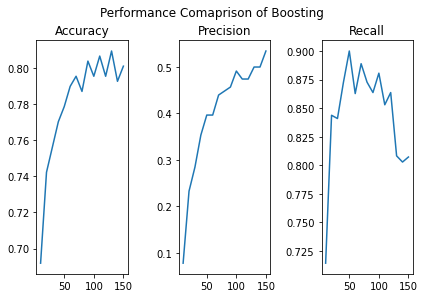

In [112]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Boosting', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
fig.tight_layout()

In [115]:
## Bagging
from sklearn.ensemble import BaggingClassifier

In [144]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(BaggingClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)
score_df = pd.DataFrame(score_list)
score_df

,count,accuracy,precision,recall
0,100,0.840336,0.646552,0.812500
1,110,0.865546,0.672414,0.898876
2,120,0.854342,0.715517,0.843750
3,130,0.868347,0.663793,0.831579
4,140,0.840336,0.681034,0.826087
5,150,0.840336,0.637931,0.852273


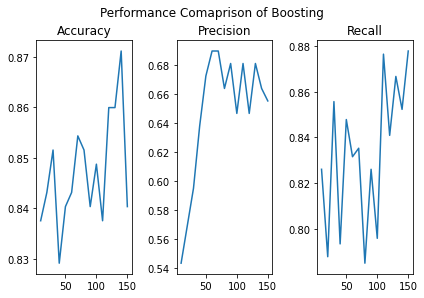

In [117]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Boosting', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
fig.tight_layout()

In [118]:
## Random Forest

In [139]:
score_list = []
for steps in range(100, 160, 10):
    scores = {}
    scores['count'] = steps
    scores['accuracy'] = accuracy_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['precision'] = precision_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    scores['recall'] = recall_score(RandomForestClassifier(n_estimators=steps).fit(X_train, y_train).predict(X_test), y_pred)
    score_list.append(scores)
score_df = pd.DataFrame(score_list)

In [142]:
score_df

,count,accuracy,precision,recall
0,100,0.789916,0.474138,0.803030
1,110,0.789916,0.448276,0.880597
2,120,0.803922,0.474138,0.809524
3,130,0.798319,0.431034,0.789474
4,140,0.823529,0.491379,0.777778
5,150,0.789916,0.448276,0.820896


Text(0.5, 1.0, 'Recall')

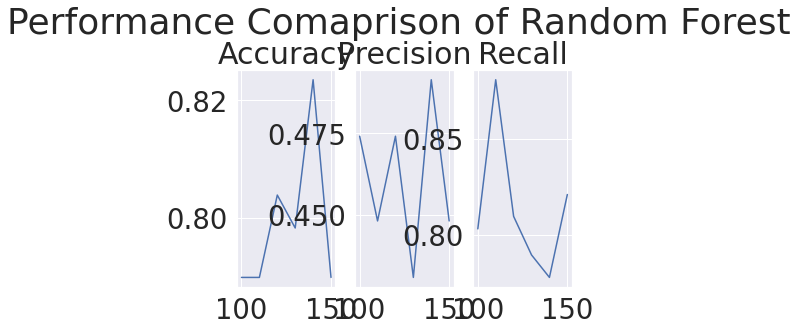

In [141]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Performance Comaprison of Random Forest', va='bottom')
ax1.plot(score_df['count'], score_df['accuracy'])
ax2.plot(score_df['count'], score_df['precision'])
ax3.plot(score_df['count'], score_df['recall'])
ax1.set_title('Accuracy')
ax2.set_title('Precision')
ax3.set_title('Recall')
# fig.tight_layout()

In [143]:
for step in [100,110,120,130, 140, 150]:
    clf = RandomForestClassifier(n_estimators=step)
    clf.fit(X_train, y_train)
    importances = clf.feature_importances_
    std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    best_10 = indices[0:10]
    print("=============For Tree Count " + str(step) + " ===================")
    for i in best_10:
        print(feature_names[i])

=============For Tree Count 100 ===================
W__coronavirus
W__china coronavirus
W__china
W__think
W__peopl
W__latest
W__happen
W__infect
W__news
W__chines
=============For Tree Count 110 ===================
W__coronavirus
W__infect
W__china coronavirus
W__china
W__happen
W__latest
W__think
W__news
W__world
W__peopl
=============For Tree Count 120 ===================
W__coronavirus
W__china
W__peopl
W__chines
W__news
W__infect
W__china coronavirus
W__corona
W__happen
W__don
=============For Tree Count 130 ===================
W__coronavirus
W__china
W__china coronavirus
W__think
W__news
W__peopl
W__happen
W__chines
W__world
W__infect
=============For Tree Count 140 ===================
W__coronavirus
W__infect
W__china coronavirus
W__peopl
W__china
W__chines
W__world
W__happen
W__latest
W__news
=============For Tree Count 150 ===================
W__coronavirus
W__china
W__infect
W__china coronavirus
W__news
W__happen
W__latest
W__think
W__chines
W__corona


In [ ]:
def categorize_label(row):
    if row['FCFR'].lower() == 'relieving':
        row['FCFR'] = 0
    else:
        row['FCFR'] = 1
    return row
data = data.apply(lambda row: categorize_label(row), axis =1)